# Run 4 : MLP

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Word2Vec
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# courbe roc 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

### Chargement des données d'apprentissage et de test

In [2]:
df_train = pd.read_csv("../data/train.csv", sep=',', encoding='utf-8')
df_validation = pd.read_csv("../data/validation.csv", sep=',', encoding='utf-8')
df_test = pd.read_csv("../data/test.csv", sep=',', encoding='utf-8')

### Vectorisation des données avec Word2Vec et encodage des labels

In [3]:
stop_words = set(stopwords.words('french'))

df_train['vecteur'] = df_train['titre'] + " " + df_train['recette']
df_validation['vecteur'] = df_validation['titre'] + " " + df_validation['recette']
df_test['vecteur'] = df_test['titre'] + " " + df_test['recette']

# tokenisation 
def tokenize_text(text):
    tokens = word_tokenize(text, language="french")
    mal_segmentes = [t for t in tokens if "'" in t]
    tokens = [word.lower() for word in tokens if word.isalpha() and word not in stop_words]
    return tokens

df_train['tokenize_text'] = df_train['vecteur'].apply(tokenize_text)
df_validation['tokenize_text'] = df_validation['vecteur'].apply(tokenize_text)
df_test['tokenize_text'] = df_test['vecteur'].apply(tokenize_text)

# modèle Word2Vec 
model = Word2Vec(sentences=df_train['tokenize_text'], vector_size=100, window=5, min_count=1, workers=4)

# vecteur pour une phrase
def get_vector(words, model):
    words = [word for word in words if word in model.wv]
    return np.mean(model.wv[words], axis=0)

# transformation en vecteur 
x_train = np.array(df_train['tokenize_text'].apply(lambda words: get_vector(words, model)).tolist())
x_validation = np.array(df_validation['tokenize_text'].apply(lambda words: get_vector(words, model)).tolist())
x_test = np.array(df_test['tokenize_text'].apply(lambda words: get_vector(words, model)).tolist())

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_train["type"])
y_validation = label_encoder.transform(df_validation["type"])
y_test = label_encoder.transform(df_test["type"])

### Conversion des données en tensors PyTorch

In [4]:
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
x_validation = torch.tensor(x_validation, dtype=torch.float32)
y_validation = torch.tensor(y_validation, dtype=torch.long)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

In [5]:
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=150, shuffle=True)

validation_dataset = TensorDataset(x_validation, y_validation)
validation_loader = DataLoader(validation_dataset, batch_size=150, shuffle=False)

### Affichage des tailles des tensors pour adapter la taille du modèles

In [6]:
print(x_train.shape, y_train.shape)
print(x_validation.shape, y_validation.shape)
print(x_test.shape, y_test.shape)

torch.Size([11225, 100]) torch.Size([11225])
torch.Size([1248, 100]) torch.Size([1248])
torch.Size([1388, 100]) torch.Size([1388])


### Modèle

In [7]:
device = torch.device('cpu')

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = nn.Linear(100, 256) # 256 neurones 
        self.c2 = nn.Linear(256, 256) 
        self.c3 = nn.Linear(256, 3) 
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.c1(x))
        x = self.activation(self.c2(x))
        x = self.c3(x)
        return x

model = NeuralNetwork().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

def train(dataloader, model, criterion, optimizer):
    model.train()
    train_loss = 0.0
    for batch, (x, y) in enumerate(dataloader):
        optimizer.zero_grad()
        pred = model(x.to(device))
        loss = criterion(pred, y.to(device))

        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            train_loss += loss.item()
    return train_loss/10

def test(dataloader, model, criterion):
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            pred = model(x.to(device))
            test_loss += criterion(pred, y.to(device)).item()
            _, predicted = torch.max(pred, 1)
            correct += (predicted == y.to(device)).type(torch.float).sum().item()
    test_loss /= len(dataloader)
    correct /= len(dataloader.dataset)
    print(f"Accuracy: {(100 * correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss

### Entraînement

In [8]:
loss_train = []
loss_validation = []
for epochs in range(50):
    current_loss = 0.0
    print(f"Epoch {epochs + 1}")
    loss_train.append(train(train_loader, model, criterion, optimizer))
    loss_validation.append(test(validation_loader, model, criterion))

Epoch 1
Accuracy: 78.7%, Avg loss: 0.499830 

Epoch 2
Accuracy: 82.9%, Avg loss: 0.378925 

Epoch 3
Accuracy: 80.5%, Avg loss: 0.439953 

Epoch 4
Accuracy: 81.5%, Avg loss: 0.415063 

Epoch 5
Accuracy: 83.4%, Avg loss: 0.397224 

Epoch 6
Accuracy: 83.6%, Avg loss: 0.372736 

Epoch 7
Accuracy: 81.4%, Avg loss: 0.407200 

Epoch 8
Accuracy: 83.1%, Avg loss: 0.365012 

Epoch 9
Accuracy: 82.8%, Avg loss: 0.387007 

Epoch 10
Accuracy: 82.2%, Avg loss: 0.377793 

Epoch 11
Accuracy: 83.4%, Avg loss: 0.373870 

Epoch 12
Accuracy: 83.9%, Avg loss: 0.359793 

Epoch 13
Accuracy: 82.3%, Avg loss: 0.372331 

Epoch 14
Accuracy: 83.8%, Avg loss: 0.361897 

Epoch 15
Accuracy: 83.5%, Avg loss: 0.360961 

Epoch 16
Accuracy: 82.9%, Avg loss: 0.371082 

Epoch 17
Accuracy: 84.1%, Avg loss: 0.373422 

Epoch 18
Accuracy: 83.5%, Avg loss: 0.370060 

Epoch 19
Accuracy: 83.9%, Avg loss: 0.370061 

Epoch 20
Accuracy: 82.8%, Avg loss: 0.394103 

Epoch 21
Accuracy: 82.4%, Avg loss: 0.398360 

Epoch 22
Accuracy: 83.

#### Graphique des pertes

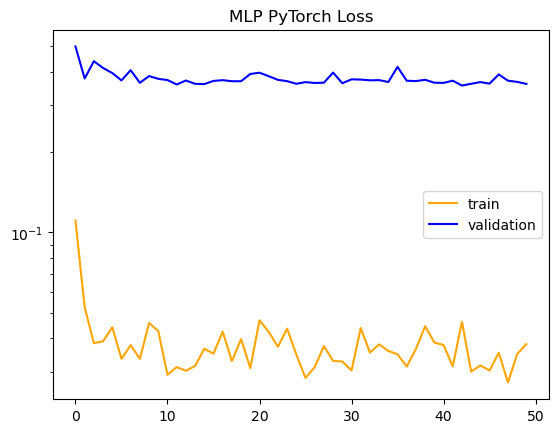

In [9]:
x = pd.Series(range(50))
plt.figure()
plt.plot(x, loss_train, color='orange')
plt.plot(x, loss_validation, color='blue')
plt.legend(['train', 'validation'])
plt.yscale('log')
plt.title("MLP PyTorch Loss")
plt.show()

### Prédiction

In [10]:
import torch.nn.functional as F

with torch.no_grad():
    y_pred = model(x_test.to(device))
    y_score = F.softmax(y_pred, dim=1)

y_pred_classes = torch.argmax(y_pred, dim=1)

### Résultats

In [11]:
score = accuracy_score(y_test, y_pred_classes)
print("Accuracy:", score, "\n")
print(classification_report(y_test, y_pred_classes), "\n")

Accuracy: 0.8422190201729106 

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       407
           1       0.66      0.78      0.71       337
           2       0.88      0.78      0.83       644

    accuracy                           0.84      1388
   macro avg       0.83      0.85      0.84      1388
weighted avg       0.85      0.84      0.84      1388
 



<Axes: >

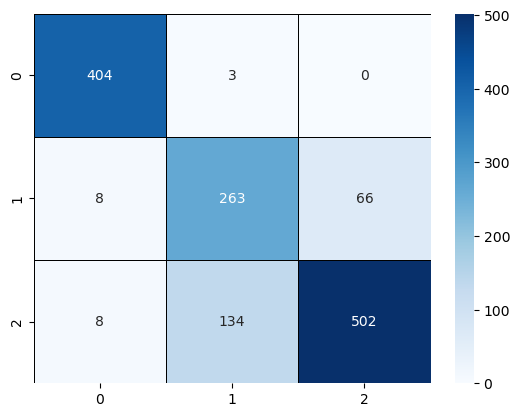

In [12]:
import seaborn as sns 
matrix = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", linewidths=0.5, linecolor="black")

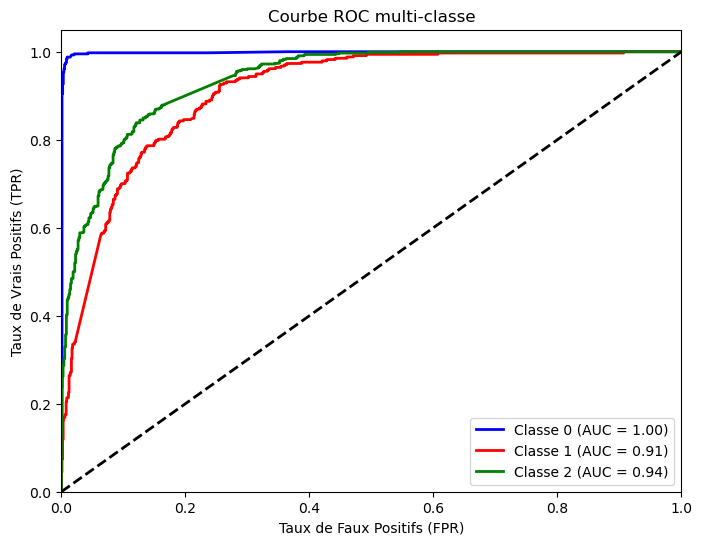

In [13]:
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)

n_classes = y_test_bin.shape[1]
colors = cycle(['blue', 'red', 'green']) 

plt.figure(figsize=(8, 6))

for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, color=color, lw=2, label=f'Classe {lb.classes_[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbe ROC multi-classe')
plt.legend(loc='lower right')
plt.show()

In [14]:
max_scores = np.max(y_score.cpu().numpy(), axis=1)
zero_count = np.sum(max_scores == 0)
half_count = np.sum(max_scores < 0.5)
one_count = np.sum((max_scores < 1) & (max_scores > 0.5))

print(f"Documents avec un score de 0   : {zero_count}")
print(f"Documents avec un score de 0.5 : {half_count}")
print(f"Documents avec un score de 1   : {one_count}")

Documents avec un score de 0   : 0
Documents avec un score de 0.5 : 16
Documents avec un score de 1   : 1372
